# Run Delphes and extract observables

Johann Brehmer, Kyle Cranmer, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

from madminer.sampling import SampleAugmenter
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')


In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'

## Load data (with tight cuts)

In [9]:
sa = SampleAugmenter(sample_dir + 'samples_tight.h5', debug=False)

22:13  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma/samples_tight.h5
22:13  Found 2 parameters:
22:13     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.1, 0.1))
22:13     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.1, 0.1))
22:13  Found 6 benchmarks:
22:13     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
22:13     morphing_basis_vector_1: cWWW = -9.39e-02, cWWWtilde = 0.07
22:13     morphing_basis_vector_2: cWWW = 0.08, cWWWtilde = -3.59e-02
22:13     morphing_basis_vector_3: cWWW = -9.48e-02, cWWWtilde = -2.79e-02
22:13     morphing_basis_vector_4: cWWW = -1.80e-04, cWWWtilde = -9.99e-02
22:13     morphing_basis_vector_5: cWWW = 0.09, cWWWtilde = 0.07
22:13  Found 26 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, e_j1, pt_j1, eta_j1, phi_j1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1_a1, deltaeta_l1_a1, deltap

## Training and test data

In [10]:
for i in range(10):
    _, _, _ = sa.extract_samples_train_local(
        theta=constant_morphing_theta([0.,0.]),
        n_samples=1000000,
        folder=sample_dir + 'train_local_tight',
        filename='train_' + str(i)
    )

22:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:13  Effective number of samples: 2286.0898276862144
22:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:13  Effective number of samples: 2286.0898276862144
22:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:13  Effective number of samples: 2286.0898276862144
22:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:13  Effective number of samples: 2286.0898276862144
22:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:13  Effective number of samples: 2286.0898276862144
22:13  Extracting training sample for local score regression. Sam

In [11]:
_, _ = sa.extract_samples_train_plain(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'validation_tight',
    filename='validation'
)

22:14  Extracting plain training sample. Sampling according to ('theta', array([0., 0.]))
22:14  Effective number of samples: 2286.0898276862144


In [12]:
x_sm, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'test_tight',
    filename='test'
)

22:14  Extracting evaluation sample. Sampling according to ('theta', array([0., 0.]))
22:14  Effective number of samples: 2291.643623954453


In [13]:
_, _, _ = sa.extract_samples_train_local(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'all_local_tight',
    filename='all',
    test_split=None
)

22:14  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
22:14  Effective number of samples: 4577.680806086658


## xsec test

In [14]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sa.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sa.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('gaussian', 0., 0.05), ('gaussian', 0., 0.05)])
)

22:14  Starting cross-section calculation
22:14  Starting cross-section calculation


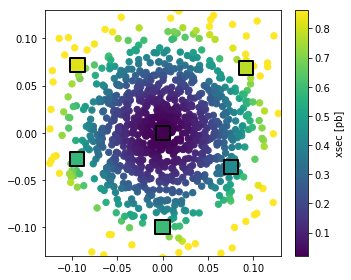

In [15]:
cmin, cmax = np.min(xsecs_benchmarks), 1.05*np.max(xsecs_benchmarks)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax,lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-0.13,.13)
plt.ylim(-0.13,.13)
plt.tight_layout()
plt.show()

## Observable distributions

In [16]:
x_bsm1, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.05,0.]),
    n_samples=1000000,
    folder=None,
    filename=None
)

x_bsm2, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.,0.05]),
    n_samples=1000000,
    folder=None,
    filename=None
)

22:14  Extracting evaluation sample. Sampling according to ('theta', array([0.05, 0.  ]))
22:14  Effective number of samples: 49.6804345767088
22:14  Extracting evaluation sample. Sampling according to ('theta', array([0.  , 0.05]))
22:14  Effective number of samples: 51.51981584905834


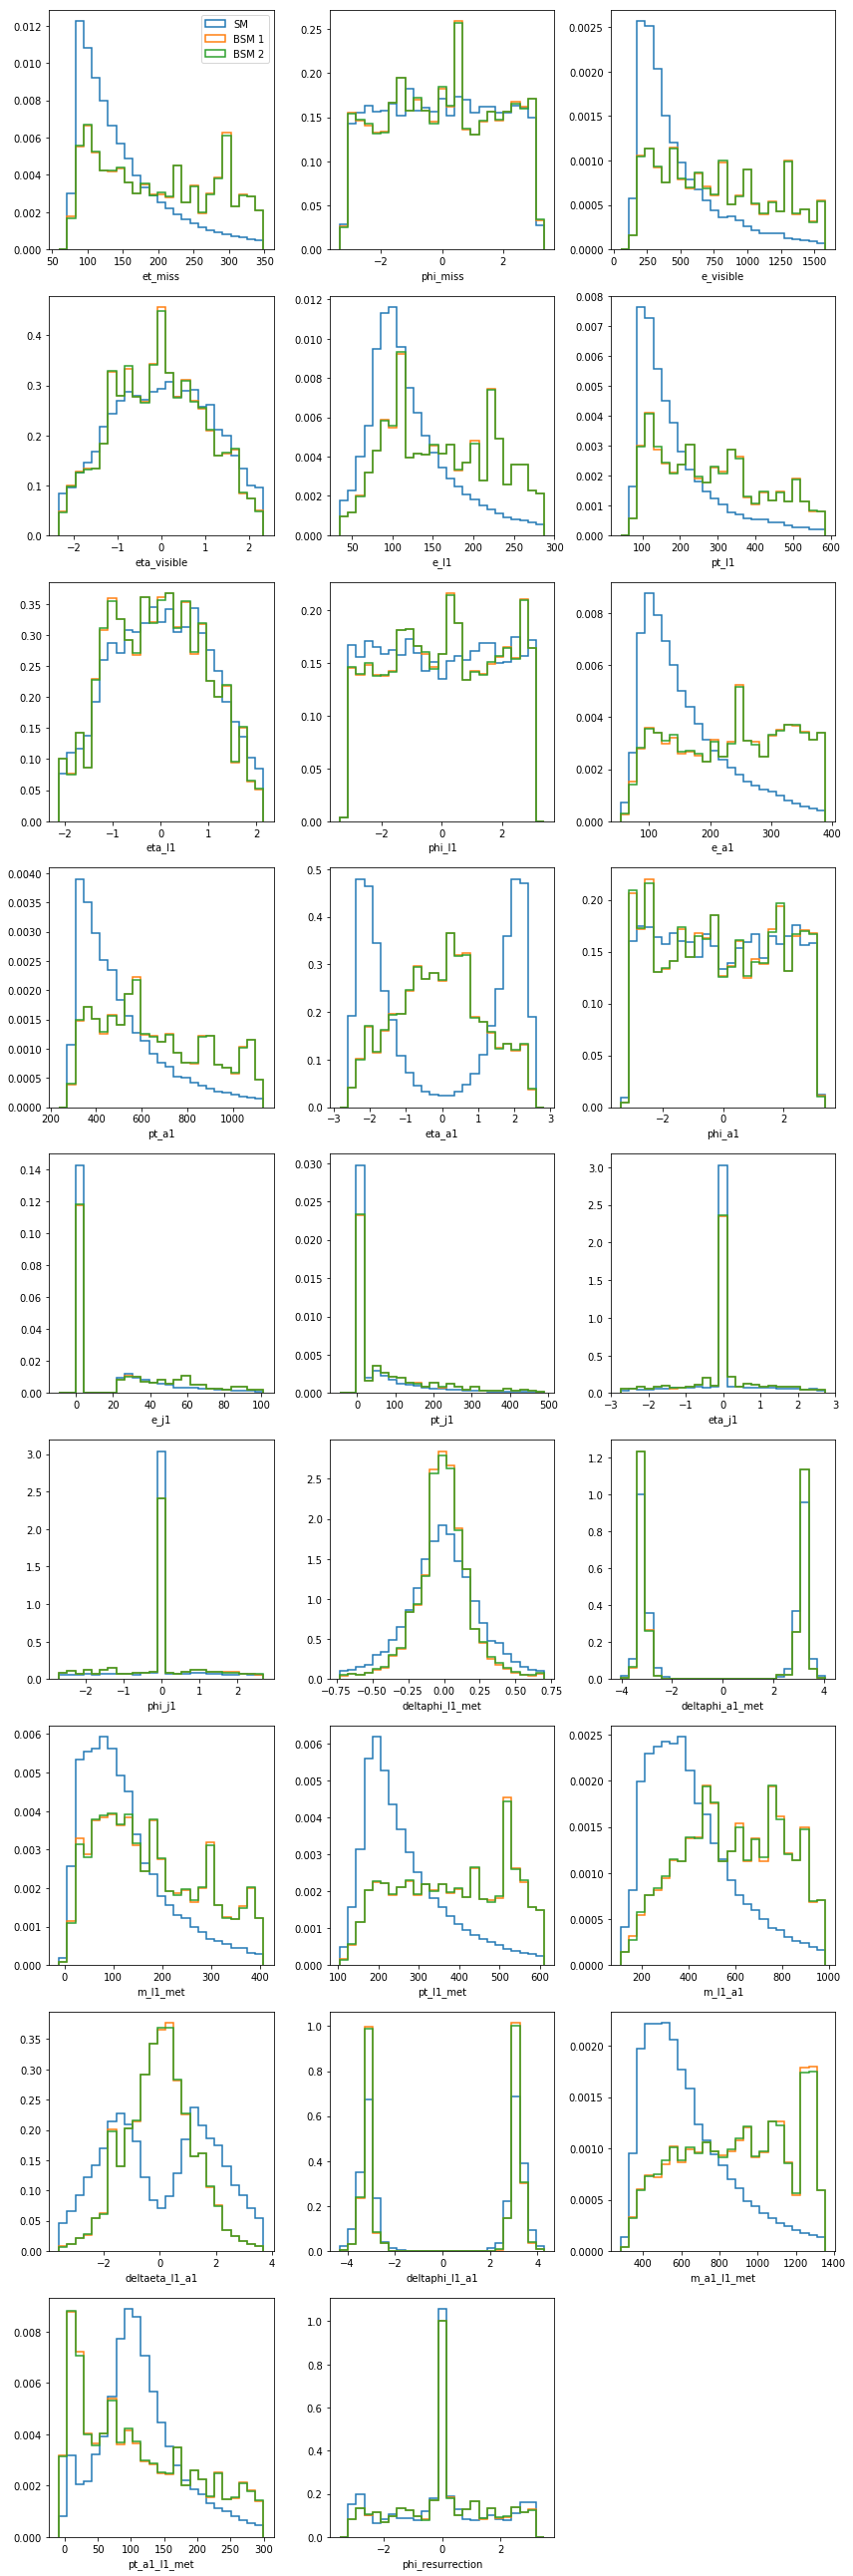

In [17]:
bins = 25
n_observables = x_sm.shape[1]
n_cols = 3
n_rows = (n_observables + n_cols - 1) // n_cols
labels = sa.observables.keys()

plt.figure(figsize=(4. * n_cols, 4. * n_rows))

for i, label in enumerate(labels):
    xmin = np.percentile(x_sm[:,i], 5.)
    xmax = np.percentile(x_sm[:,i], 95.)
    xwidth = xmax - xmin
    xmin -= xwidth * 0.1
    xmax += xwidth * 0.1
    x_range = (xmin, xmax)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
       
    plt.hist(x_sm[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'SM', density=True) 
    plt.hist(x_bsm1[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'BSM 1', density=True)
    plt.hist(x_bsm2[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'BSM 2', density=True) 
    
    if i == 0:
        plt.legend()
        
    plt.xlabel(label)
    
plt.tight_layout()
plt.show()

## Same without cuts

In [4]:
sa_all = SampleAugmenter(sample_dir + 'samples.h5', debug=False)

16:13  
16:13  ------------------------------------------------------------
16:13  |                                                          |
16:13  |  MadMiner v2018.11.02                                    |
16:13  |                                                          |
16:13  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:13  |                                                          |
16:13  ------------------------------------------------------------
16:13  
16:13  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma/samples.h5
16:13  Found 2 parameters:
16:13     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.1, 0.1))
16:13     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.1, 0.1))
16:13  Found 6 benchmarks:
16:13     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
16:13     morphing_basis_vector_1: cWWW = -9.39e-02, cWWWtilde = 0.07
16:13     morphing_basis_vector_2: cWWW = 0.

In [5]:
for i in range(10):
    _, _, _ = sa_all.extract_samples_train_local(
        theta=constant_morphing_theta([0.,0.]),
        n_samples=1000000,
        folder=sample_dir + 'train_local',
        filename='train_' + str(i)
    )

16:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:13  Effective number of samples: 46859.93555261153
16:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:13  Effective number of samples: 46859.93555261153
16:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:13  Effective number of samples: 46859.93555261153
16:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:13  Effective number of samples: 46859.93555261153
16:13  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:13  Effective number of samples: 46859.93555261153
16:13  Extracting training sample for local score regression. Sampling

In [6]:
_, _ = sa_all.extract_samples_train_plain(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'validation',
    filename='validation'
)

16:14  Extracting plain training sample. Sampling according to ('theta', array([0., 0.]))
16:14  Effective number of samples: 46859.93555261153


In [7]:
_, _ = sa_all.extract_samples_test(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'test',
    filename='test'
)

16:14  Extracting evaluation sample. Sampling according to ('theta', array([0., 0.]))
16:14  Effective number of samples: 46776.20713133652


In [8]:
_, _, _ = sa_all.extract_samples_train_local(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'all_local',
    filename='all',
    test_split=None
)

16:14  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
16:14  Effective number of samples: 93636.1166435931
